In [3]:
pip install --quiet --pre torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [4]:
!pip install -Uqq fastbook

In [5]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [6]:
#hide
from fastbook import *

In [7]:
path = untar_data(URLs.PETS)

In [8]:
#hide
Path.BASE_PATH = path

In [9]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [10]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
(path/"images").ls()

(#7393) [Path('images/Russian_Blue_205.jpg'),Path('images/chihuahua_101.jpg'),Path('images/samoyed_9.jpg'),Path('images/basset_hound_101.jpg'),Path('images/Ragdoll_164.jpg'),Path('images/havanese_146.jpg'),Path('images/yorkshire_terrier_150.jpg'),Path('images/saint_bernard_58.jpg'),Path('images/american_pit_bull_terrier_121.jpg'),Path('images/Ragdoll_186.jpg')...]

In [13]:
fname = (path/"images").ls()[0]

In [14]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Russian_Blue']

In [15]:
def ImageBlock1(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [16]:
def CategoryBlock1(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [17]:
pets = DataBlock(blocks = (ImageBlock1, CategoryBlock1),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [18]:

def _add_norm(dls, meta, pretrained):
    if not pretrained: return
    stats = meta.get('stats')
    if stats is None: return
    dls.add_tfms([Normalize.from_stats(*stats)],'after_batch')
    
_default_meta    = {'cut':None, 'split':default_split}
@delegates(create_cnn_model)
def cnn_learner1(dls, arch, normalize=True, n_out=None, pretrained=True, config=None,
                # learner args
                loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                # other model args
                **kwargs):
    "Build a convnet style learner from `dls` and `arch`"

    if config:
        warnings.warn('config param is deprecated. Pass your args directly to cnn_learner.')
        kwargs = {**config, **kwargs}

    meta = model_meta.get(arch, _default_meta)
    if normalize: _add_norm(dls, meta, pretrained)

    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_cnn_model(arch, n_out, pretrained=pretrained, **kwargs)

    splitter=ifnone(splitter, meta['split'])
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn

In [19]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [23]:
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune1(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)


In [24]:
@patch
def fit_one_cycle1(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)


In [25]:
learn.fine_tune1(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.532535,0.328196,0.112314,01:54


epoch,train_loss,valid_loss,error_rate,time
0,0.503729,0.402254,0.124493,02:28
1,0.321027,0.208217,0.065629,02:28


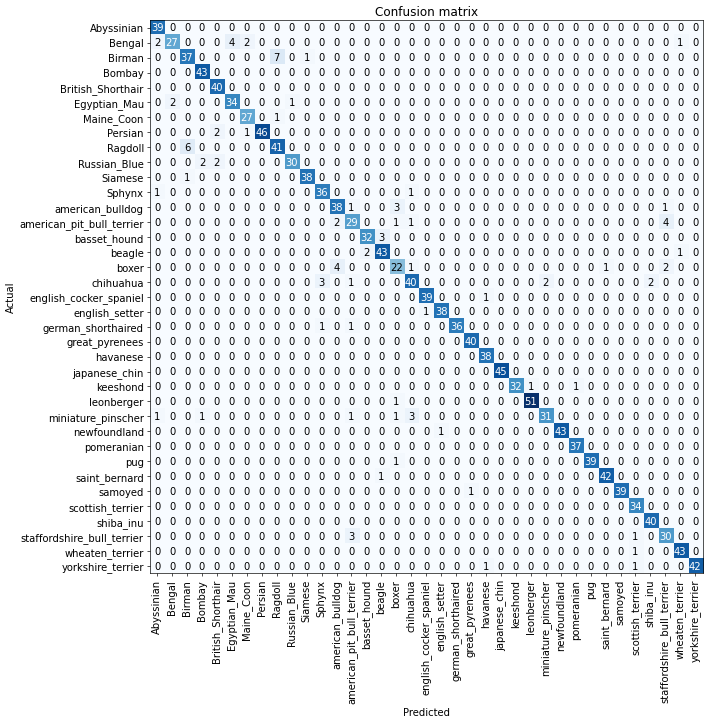

In [26]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=5)

[('Birman', 'Ragdoll', 7), ('Ragdoll', 'Birman', 6)]

In [29]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
learn.fine_tune1(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.642586,6.014873,0.477673,01:55


epoch,train_loss,valid_loss,error_rate,time
0,3.472913,2.004316,0.537212,02:28


In [31]:
@patch
def lr_find1(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)

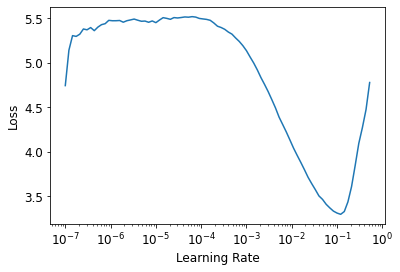

In [32]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find1()

In [33]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


In [35]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
learn.fine_tune1(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.283947,0.341554,0.109608,01:56


epoch,train_loss,valid_loss,error_rate,time
0,0.567295,0.377043,0.119756,02:29
1,0.345799,0.233478,0.073072,02:29


Unfreezing and Transfer Learning

In [37]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle1(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.152009,0.332728,0.104195,01:56
1,0.527314,0.246537,0.080514,01:56
2,0.314392,0.213078,0.073072,01:56


In [38]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

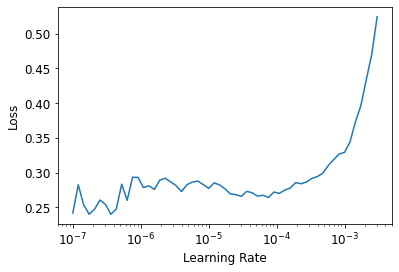

In [39]:
learn.lr_find1()

In [40]:
learn.fit_one_cycle1(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.275269,0.210788,0.069012,02:30
1,0.245607,0.205319,0.069689,02:29
2,0.239040,0.201891,0.067659,02:30
3,0.199360,0.194250,0.064276,02:30
4,0.195856,0.193500,0.064953,02:30
5,0.192576,0.192675,0.060217,02:30
